<h1><center>Customer Churn Prediction with XGBoost on Imbalanced Telecom Data</center>

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score

In [2]:
# Ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Load the data
df = pd.read_excel("data/CustomerChurn.xlsx")

In [4]:
# Show all columns in Pandas without truncating
pd.set_option('display.max_columns', None)

# Exploratory Data Analysis

In [5]:
# Show the data table
df.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Print (rows, columns) for the data
df.shape

(7043, 21)

In [7]:
# Print the List of Columns
list(df.columns)

['LoyaltyID',
 'Customer ID',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Tenure',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Monthly Charges',
 'Total Charges',
 'Churn']

The data is sourced from IBM's Base Samples. It contains 7043 rows and 19 columns. It is synthetic data on customer churn for a telecom company.

The data was downloaded here: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

More information about the data can be found here: https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

## Unique values

In [8]:
# Print all unique values for each column
for col in df.columns:
    print(f"{col}:")
    print(df[col].unique())

LoyaltyID:
[318537 152148 326527 ... 155157 731782 353947]
Customer ID:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Senior Citizen:
['No' 'Yes']
Partner:
['Yes' 'No']
Dependents:
['No' 'Yes']
Tenure:
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Phone Service:
['No' 'Yes']
Multiple Lines:
['No phone service' 'No' 'Yes']
Internet Service:
['DSL' 'Fiber optic' 'No']
Online Security:
['No' 'Yes' 'No internet service']
Online Backup:
['Yes' 'No' 'No internet service']
Device Protection:
['No' 'Yes' 'No internet service']
Tech Support:
['No' 'Yes' 'No internet service']
Streaming TV:
['No' 'Yes' 'No internet service']
Streaming Movies:
['No' 'Yes' 'No internet service']
Contract:
['Month-to-month' 'One year' 'Two year']
Paperless Billing:
['Yes' 'No']
Payment Method:
['Electr

Some of the features have possible values that are dependent on another feature. For example, Multiple Lines has 'No phone service' as a possible value. When it takes values of 'Yes' or 'No', it implies the user has phone service. 

When modeling, 'Phone Service' and 'Internet Service' woiuld have to be excluded in order to prevent issues with independence/autocorrelation. Considering how phone service and internet service could be determined from other columns, it would probably be better to remove those columns entirely.

## Data types

In [9]:
# Check data types for each column
df.dtypes

LoyaltyID              int64
Customer ID           object
Senior Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn                 object
dtype: object

Most of the data is in object type. This makes sense as most of the data is categorical. 

LoyaltyID and Tenure are in int64. LoyaltyID should be changed to an object or string because it is an identifier rather than a numerical value.

Total Charges is an object, while Monthly Charges is in float64. Total Charges should be changed to float64 since the values are supposed to be numeric.

In [10]:
# Convert 'Total Charges' to numeric, coercing errors to NaN
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

In [11]:
# Convert LoyaltyID to an object
df['LoyaltyID'] = df['LoyaltyID'].astype('object')

In [12]:
# Verify that the data types were changed for 'LoyaltyID' and 'Total Charges'
df.dtypes

LoyaltyID             object
Customer ID           object
Senior Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn                 object
dtype: object

LoyaltyID and Total Charges were successfully changed into the appropriate data types.

## Handle Missing Values

In [13]:
# Check for nulls
print('Number of Nulls:')
print(int(df.isna().sum().sum()))

Number of Nulls:
11


In [14]:
# Find all rows with missing values
df[df.isna().any(axis=1)]

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,344543,4472-LVYGI,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,150036,3115-CZMZD,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,497688,5709-LVOEQ,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,158969,4367-NUYAO,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,470044,1371-DWPAZ,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,937662,7644-OMVMY,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,821083,3213-VVOLG,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,947028,2520-SGTTA,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,135257,2923-ARZLG,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,317862,4075-WKNIU,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


There are only null valuies for the Total Charges column. Since there happens to be values for the Monthly Charges for each row, we can impute the missing values with the corresponding Monthly Charges. What happened was probably that the users are new and just had their first Monthly Charge. We will impute the missing values with the corresponding Monthly Charge.

In [15]:
# Impute nulls with Monthly Charges
df.loc[df['Total Charges'].isna(), 'Total Charges'] = df.loc[df['Total Charges'].isna(), 'Monthly Charges']

In [16]:
# Check for nulls
print('Number of Nulls:')
print(int(df.isna().sum().sum()))

Number of Nulls:
0


There are no rows with missing values in the data anymore. To further verify if the imputation was done correctly, let's find the rows that had their missing values imputed. 

We will use the LoyaltyID of those rows to filter the data.

In [17]:
# Check some of the previous rows with missing values
df[df['LoyaltyID'].astype(str).isin(['344543', '150036', '497688'])]

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,344543,4472-LVYGI,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,No
753,150036,3115-CZMZD,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,20.25,No
936,497688,5709-LVOEQ,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,80.85,No


Here are some of the rows, and we can see that the Total Charges are now the same as the Monthly Charges for these users.

## Remove Any Extra White Space in the Data

In [18]:
# Select columns that are objects
cat_cols = df.select_dtypes(include=['object']).columns

# Remove any extra white space
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype(str).str.strip())

## Check for Duplicate Rows

In [19]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


## Summary Statistics

In [20]:
# Summary Statistics
df.describe()

,Tenure,Monthly Charges,Total Charges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.798992
std,24.559481,30.090047,2266.730170
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


The Summary Statistics table is only printed for the 3 non-object columns. 

From the means, mins, and maxes, the values seem similar in magnitude have significant differences in magnitude between Total Charges and the other 2 features. 

Tenure, although hard to tell just looking at feature name, is in months. The value of 72 represents 6 years. Half of the company's customers have stayed with them for around 2 and a half years.

In [21]:
# Filter the data for Total Charges over $8000 and having 72 months of Tenure
df[(df['Total Charges'] > 8000) & (df['Tenure'] == 72)]

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
193,113529,9680-NIAUV,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Credit card (automatic),109.70,8129.30,No
198,868830,7255-SSFBC,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),112.25,8041.65,No
369,116254,3520-FJGCV,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),112.60,8126.65,No
437,173159,4376-KFVRS,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,No
464,289423,1480-BKXGA,Yes,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,8404.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,456645,2193-SFWQW,No,Yes,Yes,72,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),111.95,8033.10,No
6118,717232,9924-JPRMC,No,No,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.20,8547.15,No
6403,183948,3258-ZKPAI,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.60,8337.45,No
6728,382019,2380-DAMQP,No,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Electronic check,115.15,8349.70,No


In [22]:
8684/72

120.61111111111111

The range of values look reasonable. This is true even for the values of Total Charges at or close to the max. These rows translate to around $120 per month over their tenure.

Considering how reasonable the values appear, we will consider the data free from outliers and refrain from further action in order to preserve data integrity. We will also be using XGBoost for the model, which is robust to outliers when used for classification tasks such as our Customer Churn Prediction.

## Correlation Heatmap

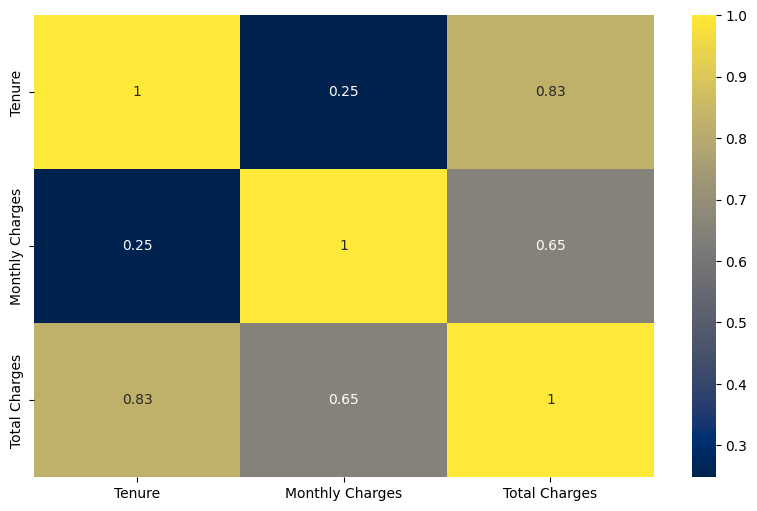

In [23]:
# Select columns that are not objects
num_cols = df.select_dtypes(exclude=['object']).columns

# Find the correlation matrix
corr = df[num_cols].corr()

# Construct the Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt='.2g', cmap='cividis')
plt.savefig('numerical_heatmap')
plt.show()

Tenure has high 0.83 correlation with Total Charges, which is reasonable considering the longer a customer stays with the company, the larger the accumulation of their charges. 

Monthly Charges has a moderate 0.65 correlation with Total Charges. This likely means that customers have a tendency to change their plans, and by extension, their Monthly Charges rather than sticking to the same plan. 

## Plot Categorical Variable Counts

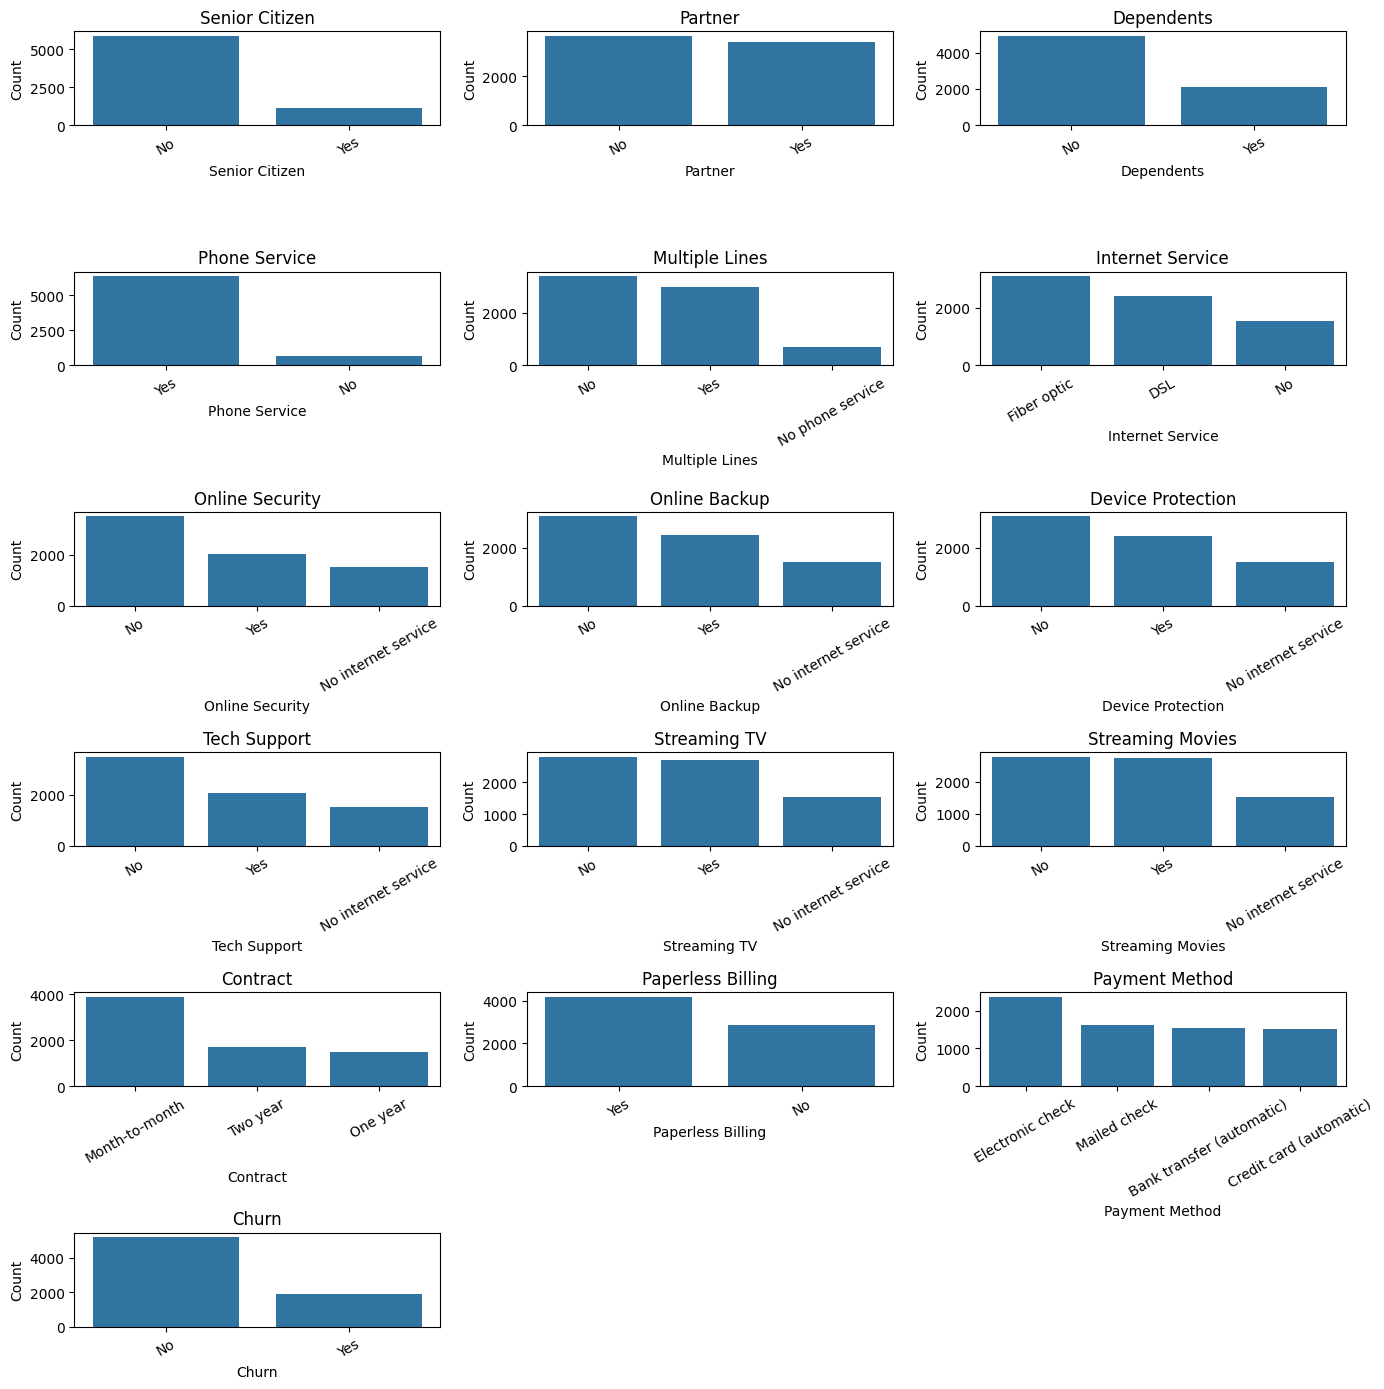

In [24]:
# Find Categorical Columns to plot
cat_cols_to_plot = [col for col in df.select_dtypes(include=['object']).columns 
                    if col not in ['LoyaltyID', 'Customer ID']]

# Set subplots
fig, axes = plt.subplots(6, 3, figsize=(14, 14))
axes = axes.flatten() 

# Make the bar plots
for i, column in enumerate(cat_cols_to_plot):
    sns.countplot(data=df, x=column, ax=axes[i], order=df[column].value_counts().index)
    axes[i].set_title(f"{column}")
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=30)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('categorical_var_counts')
plt.show()

From the plots of the counts for each feature, we see there is some imbalance for each feature except for Partner. Telecom data tends to have imbalanced data. 

For the time being, we will proceed without taking action to balance the data, as it may be better to have the model work with what may be naturally imbalanced data. If we forcefully balance it, that may introduce biases.

## Plot Distributions of Numerical Features

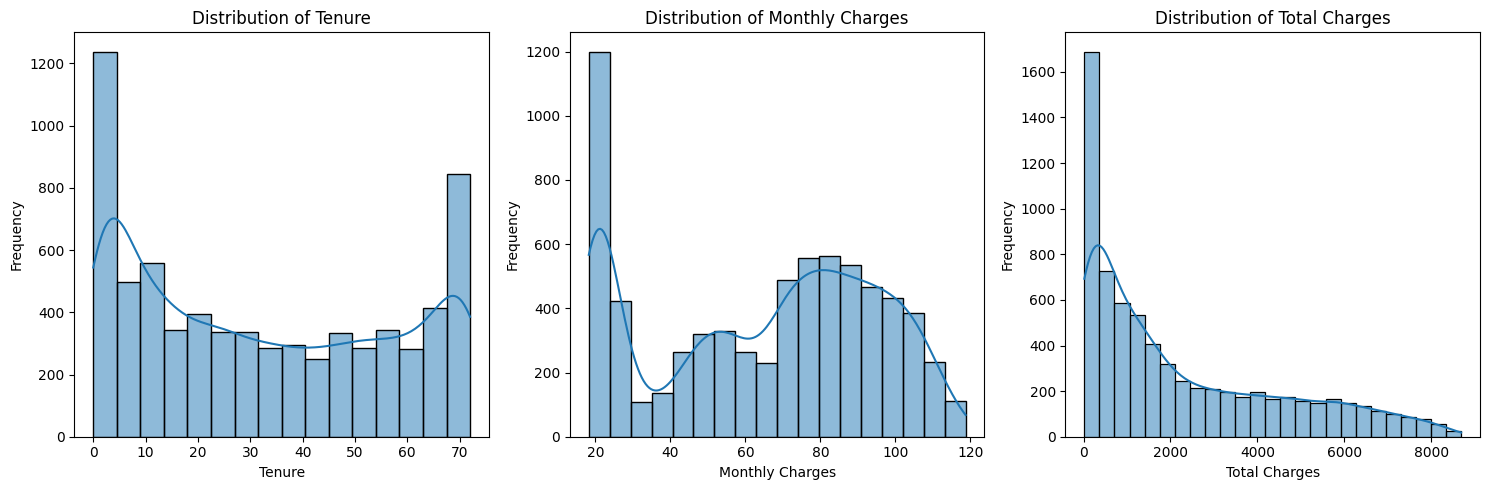

In [25]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('numerical_distributions')
plt.show()

The features do not have normal distributions. Tenure and Monthly Charges are multimodal, while Total Charges is right skewed.

# Modeling

XGBoost will be used as the model to predict customer churn. XGBoost is a tree type model that trains first using a base learning, then computes the errors. It will then train to reduce those errors and compute new errors, repeating the process until a stopping condition is met. XGBoost can be used for both classification and regression tasks. For this project, churn prediction is a classification task. 

The evaluation metric best suited for the situation is aucpr. This is the area under the Precision - Recall Curve and it is chosen since the data is imbalanced and correctly predicting whether customers will churn is top priority. 

3 Models were developed using different techniques.

## Transform Numerical Features

In [26]:
# Apply Yeo-Johnson transformation to numerical features
pt = PowerTransformer(method='yeo-johnson')
df_transformed = df.copy()
df_transformed[num_cols] = pt.fit_transform(df_transformed[num_cols])
df_transformed.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,-1.644343,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,-1.158541,-1.805206,No
1,152148,5575-GNVDE,No,No,No,0.297205,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,-0.239492,0.256861,No
2,326527,3668-QPYBK,No,No,No,-1.495444,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,-0.342665,-1.381338,Yes
3,845894,7795-CFOCW,No,No,No,0.646327,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),-0.731079,0.235865,No
4,503388,9237-HQITU,No,No,No,-1.495444,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0.213545,-1.244141,Yes


The data is transformed to take into account the skewed distribution. Since we will be using XGBoost for the model, the data will not need to be scaled. Also, Total Charges which is some high correlations to Monthly Charges and Tenure will be removed here as well.

In [27]:
# Drop the total Charges column
df_transformed = df_transformed.drop(columns='Total Charges')
# Make a copy of the dataframe
df_transformed_copy = df_transformed.copy()

## Encode Categorical Features

In [28]:
# Find Binary Columns
binary_cols = ['Senior Citizen', 'Partner', 'Dependents', 'Paperless Billing', 'Churn']

# Encoding Binary Columns
for col in binary_cols:
    df_transformed[col] = df_transformed[col].map({'No': 0, 'Yes': 1})

In [29]:
# Set Additional Service Columns
add_service_cols = [
    'Multiple Lines', 'Online Security', 'Online Backup',
    'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies'
]

# Encoding Additional Service Columns
df_transformed = pd.get_dummies(df_transformed, columns=add_service_cols, drop_first=True, dtype=int)

In [30]:
# Set Other Columns (Contract and Payment Method)
other_cols = ['Contract', 'Payment Method']

# Encoding Other Columns
df_transformed = pd.get_dummies(df_transformed, columns=other_cols, drop_first=True, dtype=int)

In [31]:
# Print first 5 rows of data
df_transformed.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Internet Service,Paperless Billing,Monthly Charges,Churn,Multiple Lines_No phone service,Multiple Lines_Yes,Online Security_No internet service,Online Security_Yes,Online Backup_No internet service,Online Backup_Yes,Device Protection_No internet service,Device Protection_Yes,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,318537,7590-VHVEG,0,1,0,-1.644343,No,DSL,1,-1.158541,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,152148,5575-GNVDE,0,0,0,0.297205,Yes,DSL,0,-0.239492,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,326527,3668-QPYBK,0,0,0,-1.495444,Yes,DSL,1,-0.342665,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,845894,7795-CFOCW,0,0,0,0.646327,No,DSL,0,-0.731079,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,503388,9237-HQITU,0,0,0,-1.495444,Yes,Fiber optic,1,0.213545,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Check Unique Values for Each Feature

In [32]:
# Print all unique values for each column
for col in df_transformed.columns:
    print(f"{col}:")
    print(df_transformed[col].unique())

LoyaltyID:
['318537' '152148' '326527' ... '155157' '731782' '353947']
Customer ID:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Senior Citizen:
[0 1]
Partner:
[1 0]
Dependents:
[0 1]
Tenure:
[-1.6443435   0.29720527 -1.49544443  0.64632675 -0.92628704 -0.16269601
 -0.78871081  0.08053824  1.10445427 -0.60622285 -0.44435051  1.00352171
  0.76159927 -0.03718286  1.27288016  0.84473766  1.31927073 -0.2065339
 -0.66440415  0.15530631  0.70462831  1.34219847 -0.39396295  0.04208131
 -1.16936305  0.67564931 -0.72512119  1.29616592  1.12912864  0.58660355
 -0.49640807  1.05444632 -0.34510326  1.20189603 -0.8555903  -1.37221793
  0.19168912  0.78961168  1.15359039  0.95163168 -1.00148358  0.5561775
  0.33125677  0.7332748   0.11826746  1.17784456  0.43037665  1.2494094
  0.22744746  0.9253082   0.3978215   0.36478829  0.52535695 -1.08208957
 -1.26512968  0.26261052  1.22574947 -0.11990163  0.97770058  1.07956199
 -0.55030087 -0.25148998  0.8718688   0.4

The categories were all encoded. Drop_first was used to remove the first category/dummary variable created to remove multicollinearity issues and prevent the dummy variable trap. 

For example, the device_protection feature took values of 'Yes', 'No', or 'No internet service'. 

The dummy variables in the dataframe are 'Yes' and 'No internet service'. The category of 'No' is implied from values of 0 in the 'Yes' dummy variable.

## Feature Selection

In [33]:
# Remove unneeded or highly dependent features
features = df_transformed.drop(columns=['LoyaltyID', 'Customer ID', 'Phone Service', 'Internet Service'])

## Split the Data

In [34]:
# Set independent variables
X = features.drop(columns='Churn')

# Set dependent variable
y = features['Churn']

# Split the data at a 80:20 ratio and set the random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [35]:
features.head()

,Senior Citizen,Partner,Dependents,Tenure,Paperless Billing,Monthly Charges,Churn,Multiple Lines_No phone service,Multiple Lines_Yes,Online Security_No internet service,Online Security_Yes,Online Backup_No internet service,Online Backup_Yes,Device Protection_No internet service,Device Protection_Yes,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,1,0,-1.644343,1,-1.158541,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0.297205,0,-0.239492,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,-1.495444,1,-0.342665,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0.646327,0,-0.731079,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,-1.495444,1,0.213545,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Fit the Base Model

We will first fit an XGBoost model without setting or tuning hyperparameters to get a baseline for performance. The random state is set to 42 to get reproducible results. 

In [36]:
# Initialize the classifier
model = xgb.XGBClassifier(
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test)

### Model Validation

In [37]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7842


The accuracy is good, but the data is imbalanced and the accuracy may be from the model simply predicting 'No' for churn. 

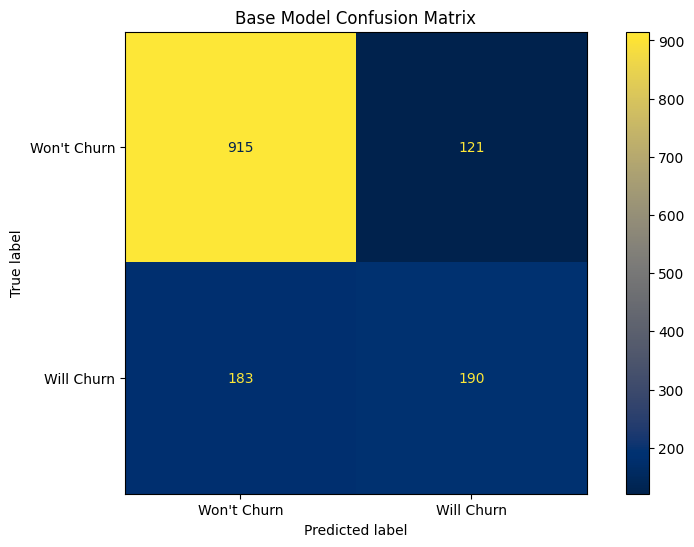

In [38]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Won't Churn", "Will Churn"])
# Construct the Confusion Matrix
disp.plot(cmap='cividis', ax=ax)
plt.title('Base Model Confusion Matrix')
plt.savefig('base_model_cm')
plt.show()

The model correctly predicts whether a customer will churn with the accuracy of a coin toss. Because the data is imbalanced (most customers don't actually churn), the model heavily favors predicting "won't churn." 

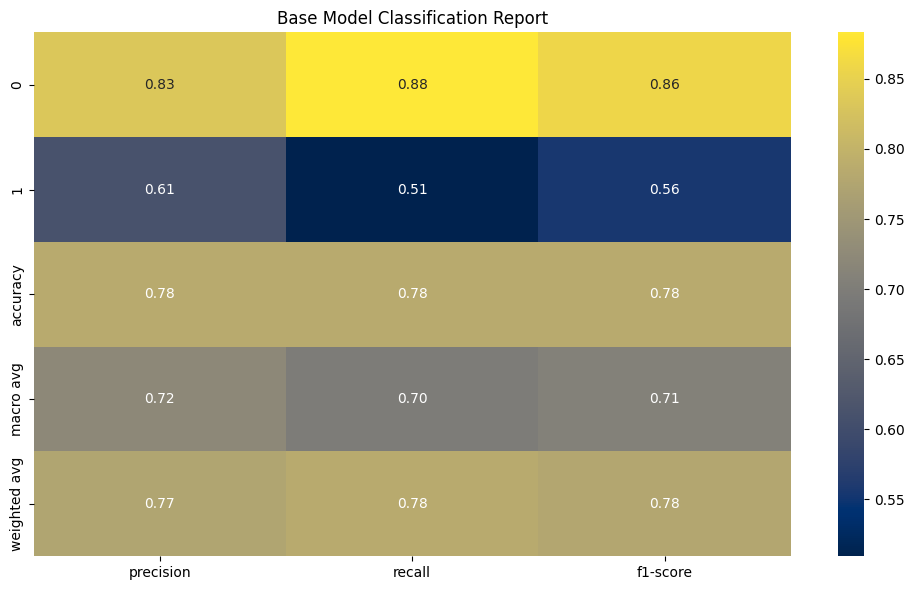

In [39]:
# Save Classification Report as dataframe and transpose
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop support column
report_df = report_df.drop(columns=['support'])
plt.figure(figsize=(10, 6))

# Construct the heatmap
sns.heatmap(report_df, annot=True, cmap='cividis', fmt=".2f")
plt.title('Base Model Classification Report')
plt.tight_layout()
plt.savefig('base_model_report.png')
plt.show()

In [40]:
# Classification report
print('Classification Report:\n')
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1036
           1       0.61      0.51      0.56       373

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



The model has high precision, recall, and f1-score for customers who don't churn. However theose metrics fall significantly when it comes to customers who do churn. For churn prediction tasks, the most important metric is recall of churned customers. The accuracy is good, but most of this accuracy comes from predicting that customers won't churn.

In [41]:
# AUC ROC score
y_pred_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8317759065078101


The ROC AUC score is high and means that the model is good at distinguishing between the 2 classes.

## Hyperparameter Tuning

We will use GridSearch to test and identify optimal hyperparameters for the best model performance. GridSearch will test all combinations of parameters in the parameter grid, recording and comparing performance to select the set of parameters that provides the best model performance. Each combination is tested by training the model and validating based on cross validation folds. 

In [42]:
# Compute the imbalance ratio
ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

# Find Hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.3],
    'reg_alpha': [0, 5],
    'reg_lambda': [1, 5],
    'scale_pos_weight': [1, round(ratio, 2)]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='aucpr', random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 5, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8}


## Fit the Tuned Model

In [43]:
# Initialize the classifier
model = xgb.XGBClassifier(
    colsample_bytree=0.8, 
    gamma=0.3, 
    learning_rate=0.05, 
    max_depth=3, 
    min_child_weight=3, 
    n_estimators=100, 
    reg_alpha=5, 
    reg_lambda=1, 
    scale_pos_weight=1, 
    subsample=0.8,
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test)

## Model Validation

In [44]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8169


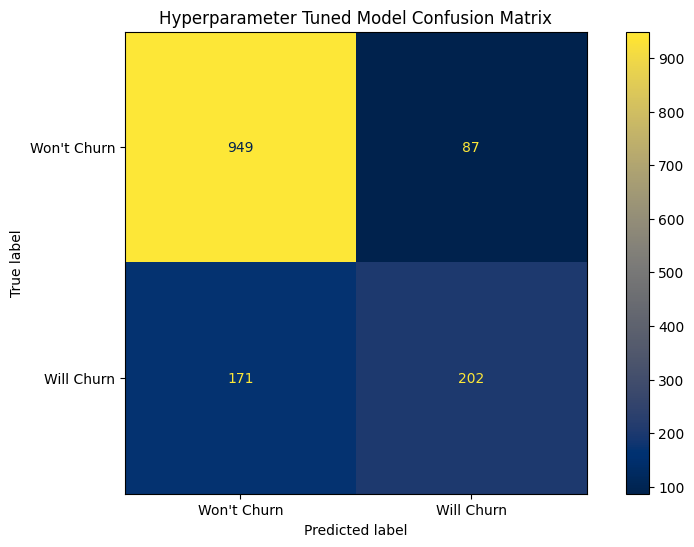

In [45]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Won't Churn", "Will Churn"])

# Plot the display
disp.plot(cmap='cividis', ax=ax)
plt.title('Hyperparameter Tuned Model Confusion Matrix')
plt.savefig('tuned_model_cm')
plt.show()

The number of True Positives and True Negatives increased while the number of False Positives and False Negatives decreased, indicating higher accuracy and better performance than the previous Base Model.

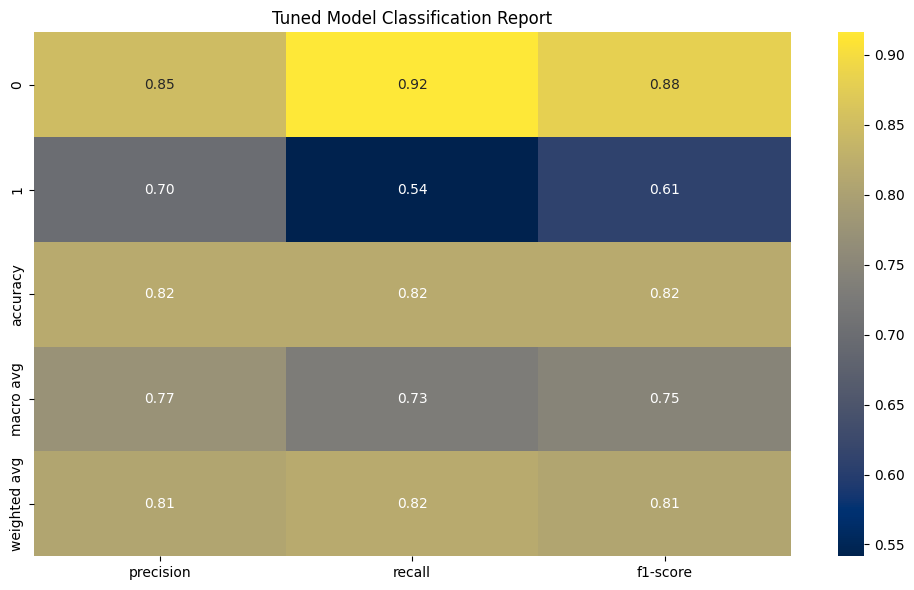

In [46]:
# Save Classification Report as dataframe and transpose
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop support column
report_df = report_df.drop(columns=['support'])

# Construct the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='cividis', fmt=".2f")
plt.title('Tuned Model Classification Report')
plt.tight_layout()
plt.savefig('tuned_model_report.png')
plt.show()

In [47]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1036
           1       0.70      0.54      0.61       373

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.82      0.81      1409



The Tuned Model has slightly increased metrics across the board, indicating better overall performance than the base model. However, it is still biased towards predicting that customers won't churn and recall for predictions of customers who will churn has not risen much.

In [48]:
# AUC ROC score
y_pred_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.863765048081402


ROC-AUC rose around 0.03 which also indicates improved performance.

## Feature Importance

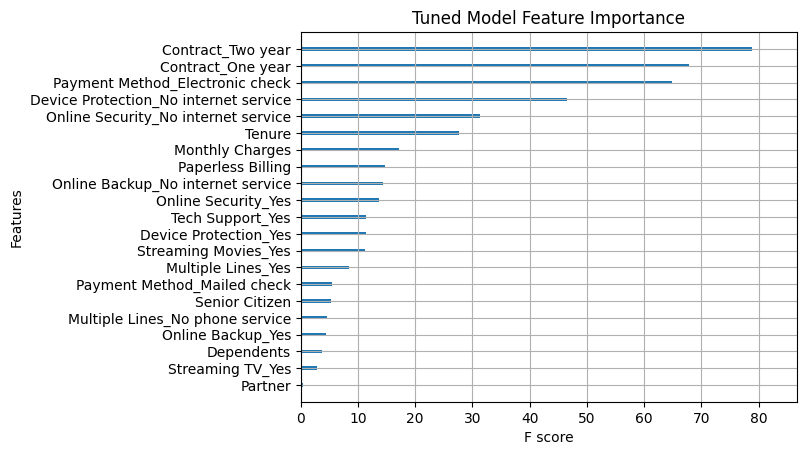

In [49]:
# Plot Feature Importance
xgb.plot_importance(model, importance_type='gain', show_values=False)
plt.title('Tuned Model Feature Importance')

# Save the figure
plt.savefig('tuned_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

The most important features in the model are the contract type. The next most important features are Payment Method, Device Protection, Online Security, Tenure, and Monthly Charges.

# SMOTE Model

## Resampling Data Using SMOTE

Synthetic Minority Oversampling Technique (SMOTE) is a method to balance data by generating some synthetic data for the minorities from existing data. Since the data is imbalanced, a method like SMOTE may improve model performance. 

In [50]:
# Setup SMOTE and random seed
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## Hyperparameter Tuning

In [51]:
# Find Hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.3],
    'reg_alpha': [0, 5],
    'reg_lambda': [1, 5],
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='aucpr', random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}


scale_pos_weight parameter was removed as that helps the model with imbalanced data. Since SMOTE was used, scale_pos_weight should be set to default values, else the model may overcompensate for the minority.

## Fit the Model and Get Predictions

In [52]:
# Set the Hyperparameters for the SMOTE model
smote_model = xgb.XGBClassifier(
    colsample_bytree=1, 
    gamma=0, 
    learning_rate=0.1, 
    max_depth=5, 
    min_child_weight=1, 
    n_estimators=100, 
    reg_alpha=0, 
    reg_lambda=1, 
    subsample=0.8,
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
smote_model.fit(X_resampled, y_resampled)

# Predict labels for the test set
y_pred_smote = smote_model.predict(X_test)

## Model Validation

In [53]:
# Accuracy
acc = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7693


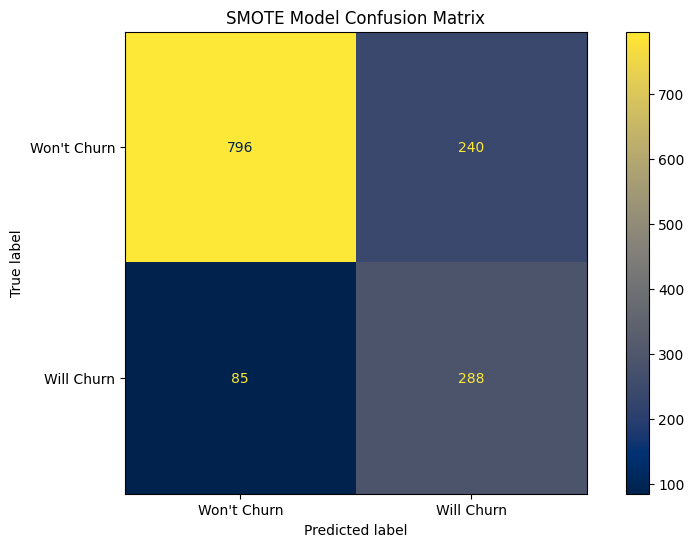

In [54]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_smote)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Won't Churn", "Will Churn"])

# Construct the Confusion Matrix
disp.plot(cmap='cividis', ax=ax)
plt.title('SMOTE Model Confusion Matrix')
plt.savefig('smote_cm')
plt.show()

The SMOTE Model has more correct predictions of when a customer will churn. It also makes fewer predictions of "Won't Churn" when a customer acutally churns. However, it makes fewer correct predictions of when a customer won't churn and makes many more mistakes where it predicts a customer will churn when they actually don't.

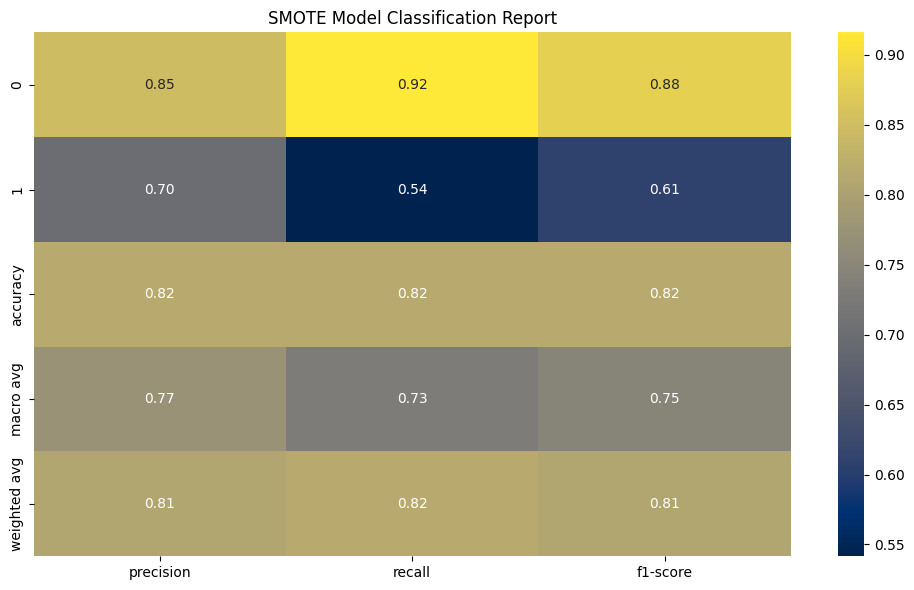

In [55]:
# Save Classification Report as dataframe and transpose
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop support column
report_df = report_df.drop(columns=['support'])

# Construct the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='cividis', fmt=".2f")
plt.title('SMOTE Model Classification Report')
plt.tight_layout()
plt.savefig('smote_report.png')
plt.show()

In [56]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_smote))

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1036
           1       0.55      0.77      0.64       373

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409



The recall for churning customers increased significantly. However this came at the tradeoff of lower precision and recall for non-churning customers and lower precision for churning customers. Overall accuracy was also lowered.

In [57]:
# AUC ROC score
y_pred_prob = smote_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8497883176167359


The ROC AUC score is slightly worse than the previous models but better than the one that did not have hyperparameter tuning done. However, the Score is still high.

## Feature Importance

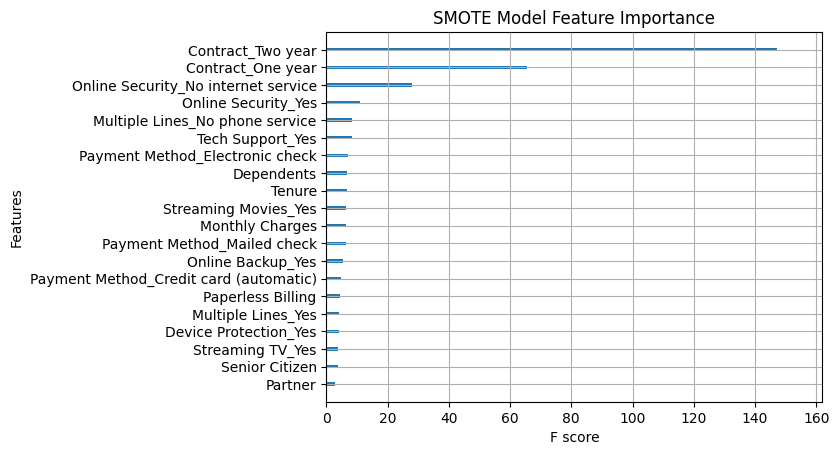

In [58]:
# Plot Feature Importance
xgb.plot_importance(smote_model, importance_type='gain', show_values=False)
plt.title('SMOTE Model Feature Importance')

# Save the figure
plt.savefig('smote_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

Contract Type and Online Security are significantly more important to the SMOTE Model than other features.

# Churn Proportion Analysis for Key Features

## Contract Churn Proportions

In [59]:
total_customers = len(df)

# Define queries and labels
contract_churns = [
    ('Churners with Month-to-Month', 'Churn == 1 and `Contract_One year` == 0 and `Contract_Two year` == 0'),
    ('Churners with 1 year', 'Churn == 1 and `Contract_One year` == 1'),
    ('Churners with 2 year', 'Churn == 1 and `Contract_Two year` == 1'),
    ('Non-Churners with Month-to-Month', 'Churn == 0 and `Contract_One year` == 0 and `Contract_Two year` == 0'),
    ('Non-Churners with 1 year', 'Churn == 0 and `Contract_One year` == 1'),
    ('Non-Churners with 2 year', 'Churn == 0 and `Contract_Two year` == 1')
]

# Print percentage for each group
for label, query in contract_churns:
    count = df_transformed.query(query).shape[0]
    pct = (count / total_customers) * 100
    print(f"{label}: {count} ({pct:.2f}%)")

Churners with Month-to-Month: 1655 (23.50%)
Churners with 1 year: 166 (2.36%)
Churners with 2 year: 48 (0.68%)
Non-Churners with Month-to-Month: 2220 (31.52%)
Non-Churners with 1 year: 1307 (18.56%)
Non-Churners with 2 year: 1647 (23.38%)


The number of churned customers is negatively correlated with contract length. Significantly more customers churned when they had Month to Month Contracts compared to customers with 1 year or 2 year contracts.

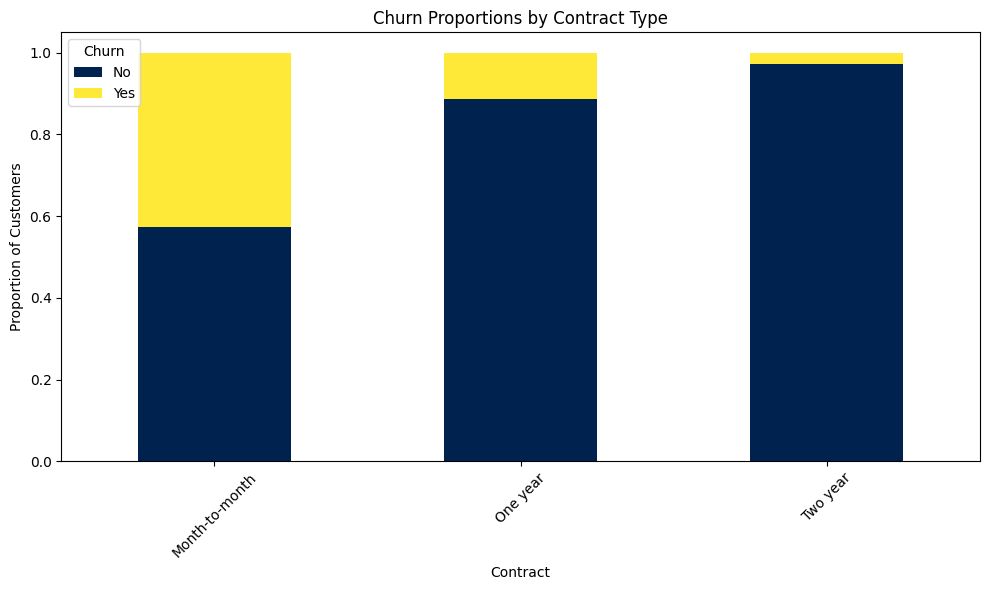

In [60]:
# Normalize to percentages
contract_churn = df.groupby(['Contract', 'Churn']).size().unstack().fillna(0)
contract_churn_pct = contract_churn.div(contract_churn.sum(axis=1), axis=0)

# Plot the stacked bar chart
contract_churn_pct.plot(kind='bar', stacked=True, colormap='cividis', figsize=(10, 6))
plt.ylabel('Proportion of Customers')
plt.title('Churn Proportions by Contract Type')
plt.xticks(rotation=45)
plt.legend(title='Churn')
plt.tight_layout()
plt.savefig('churn_by_contract')
plt.show()

The plot reflects similar results, with customers churning more often the shorter their contracts are.

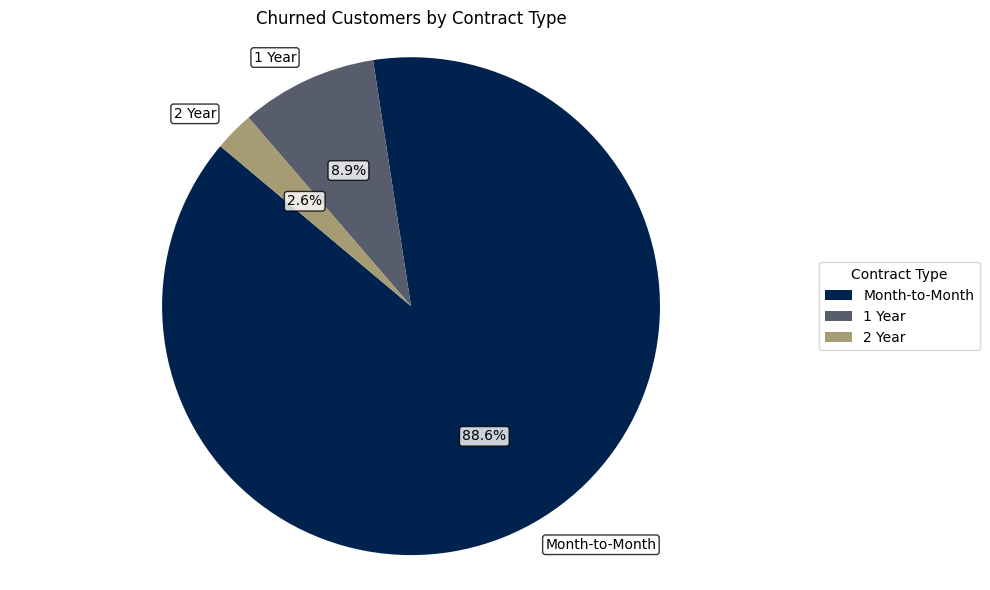

In [61]:
# Filter for only churned customers by contract type
churned_contracts = {
    'Month-to-Month': df_transformed.query('Churn == 1 and `Contract_One year` == 0 and `Contract_Two year` == 0').shape[0],
    '1 Year': df_transformed.query('Churn == 1 and `Contract_One year` == 1').shape[0],
    '2 Year': df_transformed.query('Churn == 1 and `Contract_Two year` == 1').shape[0]
}


# Extract labels and values
labels = list(churned_contracts.keys())
sizes = list(churned_contracts.values())

# Number of slices
n = len(sizes)

# Generate colors from cividis colormap
cmap = plt.get_cmap('cividis')
colors = [cmap(i / n) for i in range(n)]

# Plot the pie chart
plt.figure(figsize=(10,6))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=140,
    textprops={'color': 'black', 'bbox': dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)} # Add white textbok for visibile text
)
plt.title('Churned Customers by Contract Type')
plt.legend(wedges, labels, title='Contract Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.savefig('churn_contract_pie')
plt.show()

Of all churning customers, around 90% are on month-to-month contracts. This drops to around 9% for customers on 1 year contracts. For the company, it is of the utmost importance to get customers on 1 or 2 year contracts, which will drastically reduce churn rate.

## Internet Service Churn Proportions

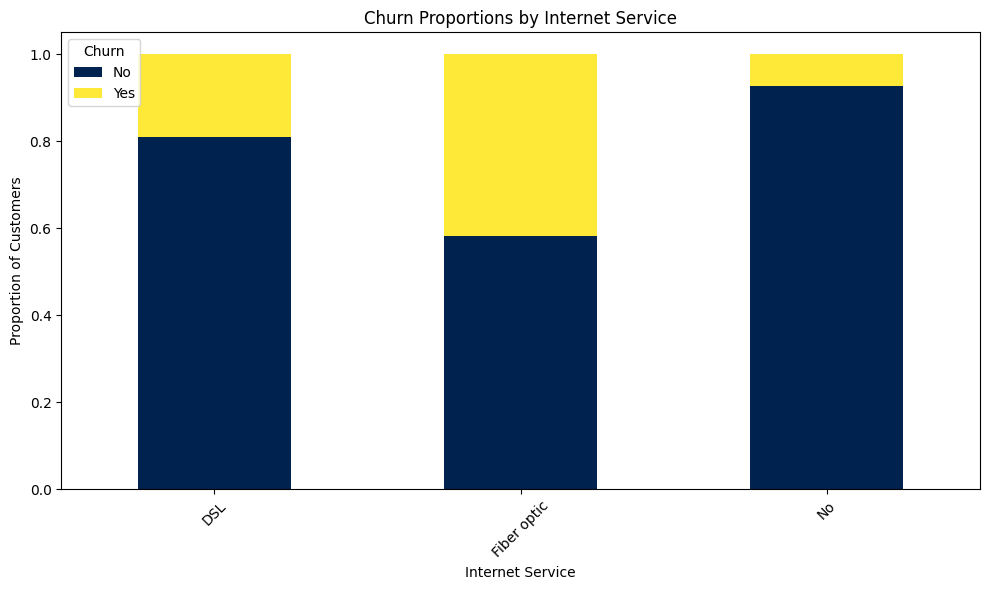

In [62]:
# Normalize to percentages
internet_churn = df.groupby(['Internet Service', 'Churn']).size().unstack().fillna(0)
internet_churn_pct = internet_churn.div(internet_churn.sum(axis=1), axis=0)

# Plot the stacked bar chart
internet_churn_pct.plot(kind='bar', stacked=True, colormap='cividis', figsize=(10, 6))
plt.ylabel('Proportion of Customers')
plt.title('Churn Proportions by Internet Service')
plt.xticks(rotation=45)
plt.legend(title='Churn')
plt.tight_layout()
plt.savefig('churn_by_internet_service')
plt.show()

There are higher proportions of customers who churn when they have internet service. Fiber Optic users also have a higher proportion of churners than DSL users.

## Payment Method Churn Proportions

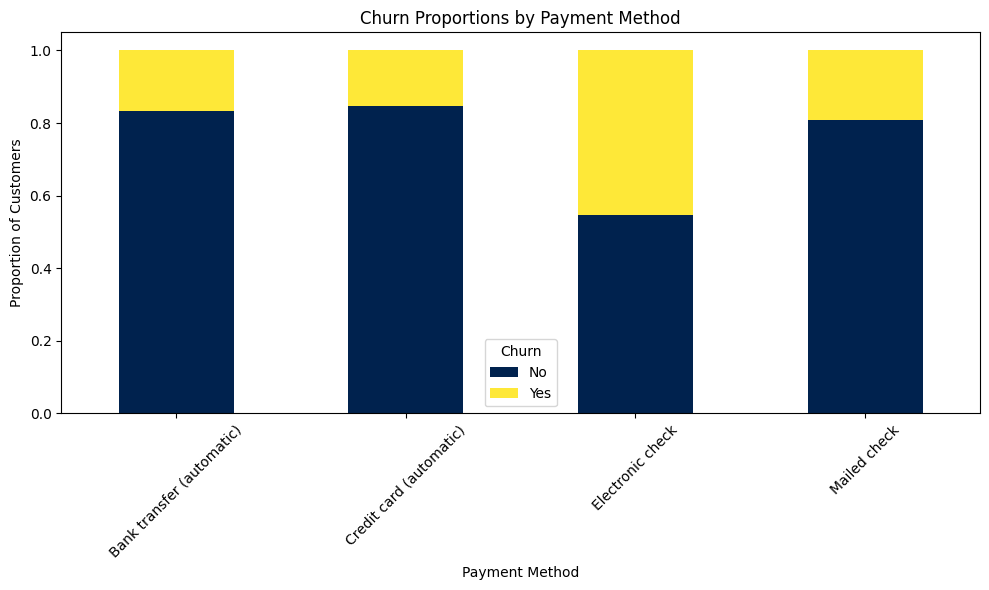

In [63]:
# Normalize to percentages
payment_churn = df.groupby(['Payment Method', 'Churn']).size().unstack().fillna(0)
payment_churn_pct = payment_churn.div(payment_churn.sum(axis=1), axis=0)

# Plot the stacked bar chart
payment_churn_pct.plot(kind='bar', stacked=True, colormap='cividis', figsize=(10, 6))
plt.ylabel('Proportion of Customers')
plt.title('Churn Proportions by Payment Method')
plt.xticks(rotation=45)
plt.legend(title='Churn')
plt.tight_layout()
plt.savefig('churn_by_payment_method')
plt.show()

Customers who pay via electronic checks have higher proportions of churning customers than those who use other payment methods (and those other payment methods have roughly the same levels of churn). This could indicate problems with the electronic check payment method.

## Tenure Churn Distribution

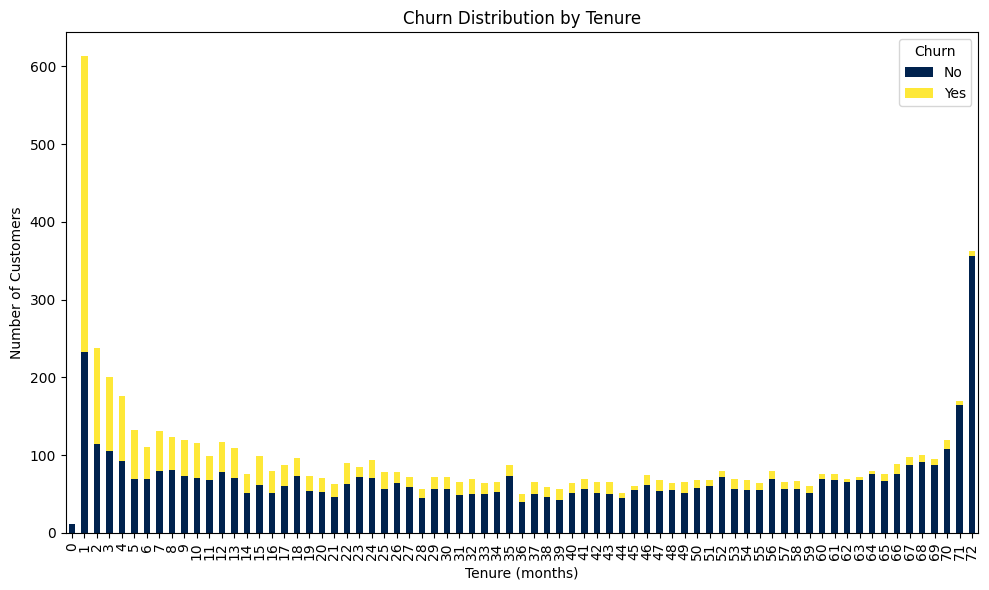

In [64]:
# Round values for Tenure
df['Tenure'] = df['Tenure'].round().astype(int)

# Create a crosstab of tenure vs. churn
tenure_churn = pd.crosstab(df['Tenure'], df['Churn'])

# Plot stacked bar chart
tenure_churn.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='cividis')
plt.title('Churn Distribution by Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Number of Customers')
plt.legend(title='Churn')
plt.tight_layout()
plt.savefig('churn_by_tenure')
plt.show()

Customers tend to churn the most within the first couple months of tenure. The first month is the most important with customers churning more in that particular month than in any other month.

# Recommendations
- For predicting customer churn, the SMOTE model should chosen despite having lower accuracy than the Base Model and Tuned Models. Because telecom data tends to be imbalanced with customer churn being the minority, models should be optimized for the highest recall, which the SMOTE Model has (around 50% improvement from the other 2 models).
- Since customers tend to churn significantly more after their first month with the telecom company, the company should prioritize deals and promotions that lock the customer into a 1 year or 2 contract.
- The company can offer customers discounted or free phones or discounts through statement credits to win over new customers, while locking them into 1 or 2 year contracts.
- Since churn rates drop substantially after the first year, the company may benefit from offering upfront incentives to encourage long-term commitments and reduce early-stage churn (which is where churn rate is the highest).

# Clarifying Questions
- Why do customers tend to churn more when they have internet services with the company?
- Are there any issues with the company's internet services such as connection speed and stability?
- Why are customers who pay with electronics checks more likely to churn than customers who pay via other methods?
- Do customers tend to have more issues with payment using this method?
- Why do customers tend to churn most often after the first 1 or 2 months with the company?
- Is the onboarding experience lacking for new customers?
- How does the company's pricing and service coverage compare to competitors?